## Part 1

In [1]:
from plotnine import *
from plotnine.themes import *
import networkx as nx
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")   

In [3]:
colors = ["#FFB482", "#A1C9F4", "#8DE5A1"]

### Functions to check graph connectivity and time required

In [4]:
# Irreducibility of the Adjacency matrix.
def method_1(G):
    A = nx.adjacency_matrix(G).todense()
    n = A.shape[0]
    exp_mat = A + np.identity(n)
    final_mat = exp_mat
    for _ in range(2, n):
        exp_mat = np.dot(exp_mat, A)
        final_mat += exp_mat
    return np.all(final_mat) > 0

# Eigenvalue of Laplacian matrix.
def method_2(G):
    return nx.algebraic_connectivity(G, method='lobpcg') > 0

# BFS.
def method_3(G):
    edges = nx.bfs_edges(G, 0)
    return len(list(edges)) == G.number_of_nodes() - 1

In [5]:
# SIMULATION ON THE SAME GRAPH.

# Time to check time of the 3 methods on a graph givena sequence of k.
def check_time(seq_k, graph_type, p=None, r=None, M=20):

    time_1, time_2, time_3 = np.empty((M, len(seq_k))), np.empty((M, len(seq_k))), np.empty((M, len(seq_k)))
    min_k = seq_k[0]

    for k in tqdm(seq_k):
        # Define graph type.
        if graph_type == 'ER':
            G = nx.erdos_renyi_graph(k, p)
        elif graph_type == 'rrg':
            G = nx.random_regular_graph(r, k)
        else: 
            print('Invalid value for graph_type!')

        for i in range(M):

            # Method 1: Check irreducibility of the adjacency matrix.
            start_time = time.time()
            check_1 = method_1(G)
            end_time = time.time()
            time_1[i, k - min_k] = end_time - start_time

            # Method 2: Check second lowest eigenvalue.
            start_time = time.time()
            check_2 = method_2(G)
            end_time = time.time()
            time_2[i, k - min_k] = end_time - start_time

            # Method 3: Check connectivity using breadth-first search algorithm.
            start_time = time.time()
            check_3 = method_3(G)
            end_time = time.time()
            time_3[i, k - min_k] = end_time - start_time

    time_data = pd.DataFrame({'k':seq_k, 'Irreducibility': time_1.mean(0), 'Eigenvalue_of_L': time_2.mean(0), 'BFS': time_3.mean(0)})


    return time_data

### Time to check connectivity of the graph with the 3 methods

In [9]:
# Get data for the plot.
seq_k = np.arange(5, 500)
time_data = check_time(seq_k, 'ER', p=0.6, r=None, M=50)

100%|██████████| 195/195 [10:27<00:00,  3.22s/it]


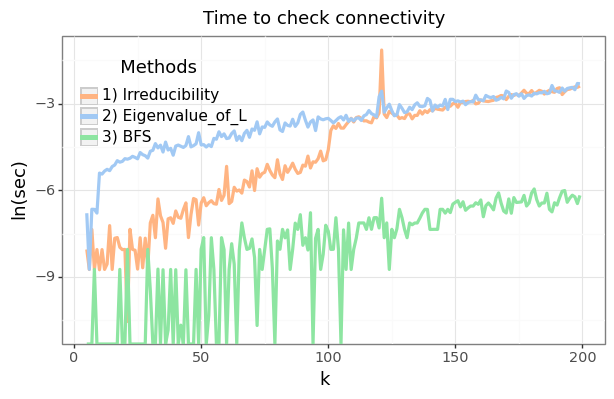

<ggplot: (144505941752)>

In [122]:
line_size = 1.3
text_size = 13

# Plot.
( ggplot(time_data) +
  aes(x='k') +
  geom_line(aes(y='np.log(Irreducibility)', color = f'"{colors[0]}"'), size = line_size) +
  geom_line(aes(y='np.log(Eigenvalue_of_L)', color = f'"{colors[1]}"'), size = line_size) +
  geom_line(aes(y='np.log(BFS)', color = f'"{colors[2]}"'), size = line_size) +
  labs(x='k', y='ln(sec)', title = 'Time to check connectivity') + 
  theme_bw() +
  theme(text=element_text(size=text_size), axis_text_x=element_text(size=text_size*.8), axis_text_y=element_text(size=text_size*.8)) +
  scale_color_manual(values=colors, guide='legend', name = '       Methods \n ', labels=['1) Irreducibility','2) Eigenvalue_of_L','3) BFS'])+
  theme(legend_key_size=13, legend_position=(.27,.73), legend_direction='vertical', figure_size=(7, 4), legend_title=element_text(size=text_size),  
        legend_text=element_text(size= text_size * 0.85), legend_background = element_rect( fill='None')))

Given that we found that the method 3 is the fastest, we use it to check connectivity for the next point.

### Connectivity probability of ER graph for all values of p

In [71]:
# Function to estimate connectivity probability taking 'num_instances' simulations.
def estimate_pc_er(seq_p, k, num_instances):
    pc_list = []
    for p in tqdm(seq_p):
        num_connected = 0
        for _ in range(num_instances):
            G = nx.erdos_renyi_graph(k, p)
            if method_3(G):
                num_connected += 1
        pc = num_connected / num_instances
        pc_list.append(pc)
    return pc_list

# Parameters.
k = 100
num_instances = 100
seq_p = np.linspace(0.08, 1, num=300)

# Estimate pc for Erdos-Reyni graphs.
pc_er = estimate_pc_er(seq_p, k, num_instances)

100%|██████████| 300/300 [01:48<00:00,  2.76it/s]


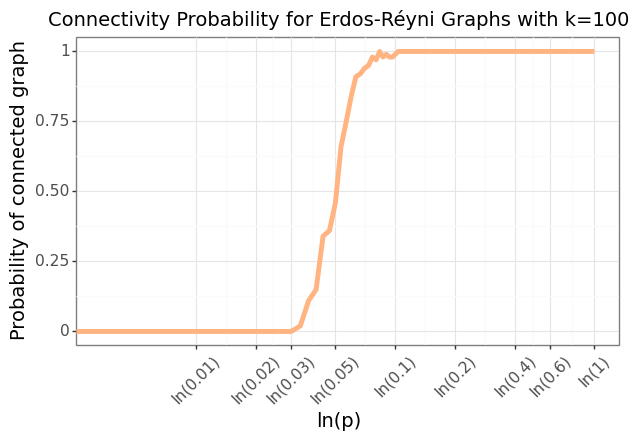

<ggplot: (144504884867)>

In [120]:
line_size = 2
text_size = 14
x_ticks = [.01, .02, .03, .05, .1,.2, .4, .6, 1]


# Plot.
( ggplot(aes(x = np.log(seq_p), y = pc_er))+
  labs(x='ln(p)',
       y='Probability of connected graph',
       title = 'Connectivity Probability for Erdos-Réyni Graphs with k=100') +
  scale_x_continuous(breaks=np.log(x_ticks), labels=[f'ln({p})' for p in x_ticks])+
  geom_line(size=line_size, color = colors[0]) +
  theme_bw()+
  theme(axis_text_x=element_text(rotation=45, hjust=1, size=text_size*.8), text=element_text(size=text_size), axis_text_y=element_text(size=text_size*.8), figure_size=(7, 4)) )

### Connectivity probability of r-regular random graph over the number of nodes

In [187]:
# Function to estimate connectivity probability taking 'num_instances' simulations.
def estimate_pc_regular(r, k, num_instances):
    pc_list = []
    for k_val in tqdm(range(r+1, k+1)):
        num_connected = 0
        for _ in range(num_instances):
            G = nx.random_regular_graph(r, k_val)
            if method_3(G):
                num_connected += 1
        pc = num_connected / num_instances
        pc_list.append(pc)
    return pc_list

# Parameters.
r_values = [2, 8]
num_instances = 100
k = 100

# Estimate pc for regular random graphs.
pc_reg = []
for r in r_values:
    pc_r = estimate_pc_regular(r, k, num_instances)
    pc_reg.append(pc_r)

100%|██████████| 92/92 [00:01<00:00, 79.62it/s] 


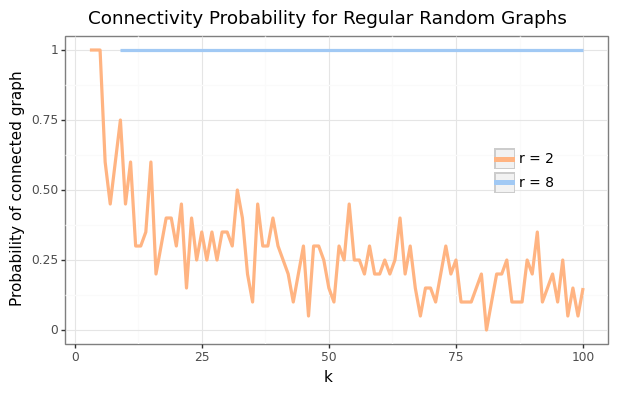

<ggplot: (99261111810)>

In [193]:
line_size = 1.3
text_size = 14

# Plot.
( ggplot() +
  aes(x = np.arange(r_values[0]+1, k+1)) +
  labs(x='k',
        y='Probability of connected graph',
        title = 'Connectivity Probability for Regular Random Graphs') +
  geom_line(aes(y=pc_reg[0], color = f'"{colors[0]}"'), size=line_size) +
  geom_line(aes(x = np.arange(r_values[1]+1, k+1),y= pc_reg[1], color=f'"{colors[1]}"'), size=line_size ) +
  theme_bw() +
  theme(axis_text_x=element_text(size=text_size*.8), text=element_text(size=text_size), axis_text_y=element_text(size=text_size*.8)) +
  scale_color_identity(guide='legend', name = '  ', breaks=colors[:2], labels=['r = 2','r = 8'])+
  theme(legend_key_size=15, legend_position=(.78,.57), legend_direction='vertical', figure_size=(7, 4),  
        legend_text=element_text(size=10), legend_background = element_rect( fill='None')))#.draw(return_ggplot=False, show=False)

## Part 2

In [6]:
from plotnine import *
from plotnine.themes import *
from scipy.stats import expon
import networkx as nx
from tqdm import tqdm
import numpy as np
import random
import fnss

### Components of our problem

- `A`: starting server
- `X`: Negative Exponential random variable
- `N`: number of servers used closest to A to split the job
- `mean_X`: E[X_i] = E[X] / N
- `C`: capacity of each link of the DC network
- `L_f`: size of input data file
- `L_o`: size of output data file
- `T_0`: fixed setup time
- `tau`: costant
- `ξ`: costant (xi)
- `T_i`: is the RTT between the origin server A and server i with $T_i = 2 \tau h_i$
- `h_i`: number of hops between server A and server i 
- `f`: fraction of original data to add to the application job data
- Each server receive ana amount of input data `L_f / N`
- Amount of output data produced by each server is a random variable $L_{0,i} \sim Unif(0, 2 * L_0 / N)$
- Average throughput $\theta_i = C \frac{\frac{1}{T_i}}{\sum_{j=1}^N \frac{1}{T_j}}$
- The `response time R` is the time elapsing since when the job is submitted to server A until the output of the job is available at server A

In [7]:
# Initial parameters.
n = 64
r = int(n / 2)

In [8]:
def fat_tree_generator(n):
    
    # Generate Fat Tree graph.
    fnss.DatacenterTopology.node = property(lambda self: self.nodes)
    G = fnss.fat_tree_topology(n)

    # Replace 'host' labels with 'server'.
    for node in G.nodes():
        if G.nodes[node]['type'] == 'host':
            G.nodes[node]['type'] = 'server'

    return G


def jellyfish_generator(r, n):

    # Generate Random Regular graph.
    G = nx.random_regular_graph(r, n)

    # Set labels.
    node_attributes = {node: {'type': 'switch'} for node in G.nodes}
    nx.set_node_attributes(G, node_attributes)

    # Add servers.
    for i in range(n, (n * r) + n):
        G.add_node(i, type = 'server')

    servers = [node for node in G.nodes() if G.nodes[node]['type'] == 'server']

    # Connect servers to switches.
    counter = r
    for i in range(n):
        for j in range(counter - r, counter):
            G.add_edge(i, servers[j])
        counter += r
    
    return G

### Fat-tree Networks

In [9]:
# Generate Fat Tree graph.
G_ft = fat_tree_generator(n)

# Check number of servers and switches.
count_server_ft = sum(1 for node in G_ft.nodes() if G_ft.nodes[node]['type'] == 'server')
count_switch_ft = sum(1 for node in G_ft.nodes() if G_ft.nodes[node]['type'] == 'switch')
print(f'Number of servers: {count_server_ft}')
print(f'Number of switches: {count_switch_ft}')

Number of servers: 65536
Number of switches: 5120


### Jellyfish Networks 

In [10]:
# Get Jellyfish network with the same number of servers of the Fat Tree.
n_switch_r_regular = int(count_server_ft / (n/2))

# Generate Jellyfish graph.
G_jelly = jellyfish_generator(r, n_switch_r_regular)

# Check number of servers and switches.
count_server_ft = sum(1 for node in G_jelly.nodes() if G_jelly.nodes[node]['type'] == 'server')
count_switch_ft = sum(1 for node in G_jelly.nodes() if G_jelly.nodes[node]['type'] == 'switch')
print(f'Number of servers: {count_server_ft}')
print(f'Number of switches: {count_switch_ft}')

Number of servers: 65536
Number of switches: 2048


In [11]:
# Info about Jellyfish network.
max_degree_node = max(G_jelly.degree(), key=lambda x: x[1])[1]
min_degree_node = min(G_jelly.degree(), key=lambda x: x[1])[1]
switch_nodes = [node for node in G_jelly.nodes() if G_jelly.nodes[node]['type'] == 'switch']
min_degree_switch = min([G_jelly.degree(node) for node in switch_nodes])

print(f'Max nodes degree: {max_degree_node} \nMin nodes degree: {min_degree_node}')
print(f'\nMin switch degree: {min_degree_switch}')

Max nodes degree: 64 
Min nodes degree: 1

Min switch degree: 64


### Parameters values

In [12]:
# Data.
C = 1e10
tau = 1e-6
Lf = 4 * 8e12
Lo = 4 * 8e12
E_X = 8 * 3600
T_0 = 30
xi = .1
f = 48 / 1500

### Algorithm to run the Simulation

In [13]:
# Find hops between A and i servers.
def find_hopes(G, A, N):
    distances = nx.single_source_shortest_path_length(G, A)
    sorted_nodes = sorted(distances, key=distances.get)
    server_nodes = [(n, distances[n]) for n in sorted_nodes if G.nodes[n]['type'] == 'server']
    return server_nodes[1:N+1]


# Find T_i given hops from the node A.
def find_T_i(G, N, A):
    A_hops = find_hopes(G, A, N)
    T_i = [2 * tau * hop[1] for hop in A_hops]
    return np.array(T_i)


# Compute theta_i given T_i.
def find_theta_i(T_i, C):
    T_i = np.array(T_i)
    theta_i = C * ((1 / T_i) / sum(1 / (T_i)))
    return theta_i


# Generate N random values Lo_i.
def find_Lo_i(Lo, N):
    Lo_i = np.random.uniform(0, 2*Lo/N, size=N)
    return Lo_i


# Compute Response Time.
def response_time(G, N, A, C, T_0, Lf, Lo, E_X, f):

    # Compute theta_i.
    T_i = find_T_i(G, N, A)
    theta_i = find_theta_i(T_i, C)

    # Compute Lo_i.
    Lo_i = find_Lo_i(Lo, N)

    # Generate N values from Negative Exponential.
    rv = expon(scale = (E_X/N))
    X_i = rv.rvs(size=N)
    # X_i = [-E_X / n * np.log(1 - x) for x in [random.random() for _ in range(N)]]

    # Compute big theta.
    Theta = T_0 + X_i

    # Response time.
    R = max( (1+f) * Lf / (N * theta_i)   +   Theta   +   (1+f) * Lo_i / theta_i )

    return R, sum(Theta)


# Run a simulation for R over N.
def simulation(G, M, list_N, C, T_0, Lf, Lo, E_X, f):
    server_nodes = [node for node in G.nodes() if G.nodes[node]['type'] == 'server']
    list_A = random.sample(server_nodes, M)

    simulations_R, simulations_Theta = [], []
    for N in tqdm(list_N):
        list_R, list_Theta = [], []
        for A in list_A:
            R, Theta = response_time(G, N, A, C, T_0, Lf, Lo, E_X, f)
            list_R.append(R)
            list_Theta.append(Theta)
        # list_R = [response_time(G, N, A, C, T_0, Lf, Lo, E_X, f) for A in list_A]
        simulations_R.append(np.mean(list_R))
        simulations_Theta.append(np.mean(list_Theta))
    
    return np.array(simulations_R), np.array(simulations_Theta)

### Simulation

In [14]:
# Baseline
R_baseline = T_0 + E_X
S_baseline = R_baseline + xi * R_baseline

# Simulation paramters.
M = 20
list_N = list(np.arange(1, 2000)) + list(np.arange(2000, 10_001, 1000))

# Simulation.
ft_R, ft_Theta = simulation(G_ft, M, list_N, C, T_0, Lf, Lo, E_X, f)
jelly_R, jelly_Theta = simulation(G_jelly, M, list_N, C, T_0, Lf, Lo, E_X, f)

# Normalization.
ft_simulation_norm = ft_R / R_baseline
jelly_simulation_norm = jelly_R / R_baseline

ft_S_norm = (ft_R + xi * ft_Theta) / S_baseline
jelly_S_norm = (jelly_R + xi * jelly_Theta) / S_baseline


100%|██████████| 2008/2008 [01:58<00:00, 17.02it/s]


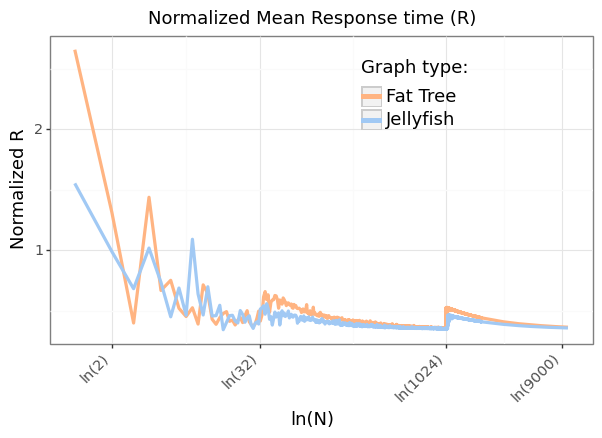

<ggplot: (187486752540)>

In [17]:
line_size = 1.3
text_size = 13
x_ticks = [2, 32, 1024, 9000]

( ggplot() +      
  aes(x = np.log(list_N)) +
  labs(x='ln(N)',
        y='Normalized R',
        title = 'Normalized Mean Response time (R)') +
  geom_line(aes(y= ft_simulation_norm, color = f'"{colors[0]}"'), size=line_size) +
  geom_line(aes(x = np.log(list_N), y= jelly_simulation_norm, color=f'"{colors[1]}"'), size=line_size ) +
  scale_x_continuous(breaks=np.log(x_ticks), labels=[f'ln({n})' for n in x_ticks]) +
  theme_bw() +
  theme(axis_text_x=element_text(size=text_size*.8), text=element_text(size=text_size), axis_text_y=element_text(size=text_size*.8)) +
  scale_color_identity(guide='legend', name = 'Graph type: \n', breaks=colors[:2], labels=['Fat Tree','Jellyfish'])+
  theme(legend_key_size=15, legend_position=(.65,.75), legend_direction='vertical', figure_size=(7, 4), legend_title=element_text(size=text_size),  
        legend_text=element_text(size=text_size), legend_background = element_rect( fill='None'), axis_text_x=element_text(rotation=45, hjust=1, size=text_size*.8)))

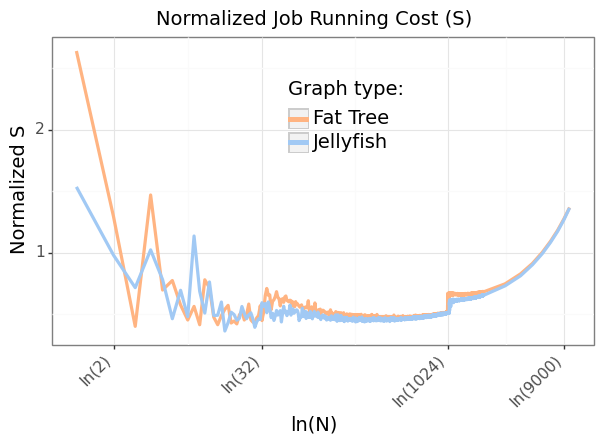

<ggplot: (187486855147)>

In [23]:
line_size = 1.3
text_size = 14
x_ticks = [2, 32, 1024, 9000]


( ggplot() +
  aes(x = np.log(list_N)) +
  labs(x='ln(N)',
        y='Normalized S',
        title = 'Normalized Job Running Cost (S)') +
  geom_line(aes(y = ft_S_norm, color = f'"{colors[0]}"'), size=line_size) +
  geom_line(aes(x = np.log(list_N), y= jelly_S_norm, color=f'"{colors[1]}"'), size=line_size ) +
  scale_x_continuous(breaks=np.log(x_ticks), labels=[f'ln({n})' for n in x_ticks]) +
  theme_bw() +
  theme(axis_text_x=element_text(size=text_size*.8), text=element_text(size=text_size), axis_text_y=element_text(size=text_size*.8)) +
  scale_color_identity(guide='legend', name = 'Graph type: \n ', breaks=colors[:2], labels=['Fat Tree','Jellyfish'])+
  theme(legend_key_size=15, legend_position=(.55,.7), legend_direction='vertical', figure_size=(7, 4), legend_title=element_text(size=text_size),  
        legend_text=element_text(size=text_size), legend_background = element_rect( fill='None'), axis_text_x=element_text(rotation=45, hjust=1, size=text_size*.8)) )